In [45]:
import torch.nn as nn
import torch

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
#                input channel , output channel, kernel size= 3x3 
conv = nn.Conv2d(3, 16, kernel_size=3) # kernel_size = (3,3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

Each output pixel is generated by 3x3 matrix. But there are 3 channels. So,
each output pixel is generated by 3x3x3 matrix. That is these many weights or parameters need to be determined.

But, the output is 16 channels. So, again we will have 16x3x3x3 weights now.
Remember, these weights are translational invariant.

Plus, there is a bias for channel output, that is, 16 bias

In [9]:
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [7]:
conv.bias.shape

torch.Size([16])

In [26]:
from torchvision import datasets
data_path = '/Users/ardhendusingh/Documents/Stanford/Pytorch_Examples/img_data/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False)       
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [13]:
type(cifar10).__mro__
len(cifar10)

50000

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FE86959EA90>, 6)

'frog'

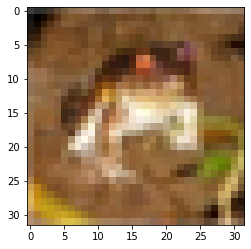

In [28]:
img, label = cifar10[0]
img, label
class_names[label]

imgplot = plt.imshow(img)

## Convert Image to Tensor

In [38]:
# an example of converting one image to tensor
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [40]:
from torchvision import transforms
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor())

img_t, _ = tensor_cifar10[99]
type(img_t)
img_t.shape, img_t.dtype

torch.Tensor

(torch.Size([3, 32, 32]), torch.float32)

In [41]:
# Whereas the values in the original PIL image ranged from 0 to 255 (8 bits per channel), 
# the ToTensor transform turns the data into a 32-bit floating-point per channel, 
# scaling the values down from 0.0 to 1.0. Let’s verify that:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

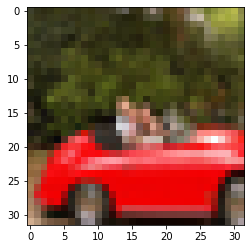

In [42]:
plt.imshow(img_t.permute(1, 2, 0))  # Changes the order of the axes from C × H × W to H × W × C
plt.show()

## Normalizing the images by means and std

In [46]:
#Let’s stack all the tensors returned by the dataset along an extra dimension:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [50]:
# mean value of image along first dimenstion. The first dimension has value 3
# the view will convert [3, 32, 32, 50000] to [3, N]
m_value = imgs.view(3, -1).mean(dim=1)  # mean value
m_value
std_value = imgs.view(3, -1).std(dim=1) # standard deviation
std_value

transforms.Normalize(m_value, std_value) # generate a normalization transform tensor

tensor([0.4915, 0.4823, 0.4468])

tensor([0.2470, 0.2435, 0.2616])

In [52]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(m_value, std_value)
    ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


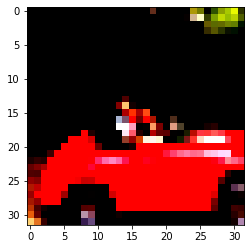

In [53]:
img_t, _ = transformed_cifar10[99]
 
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## Convert to Cifar2

In [54]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in transformed_cifar10
          if label in [0, 2]]
# cifar2_val = [(img, label_map[label])
#               for img, label in cifar10_val
#               if label in [0, 2]]

In [ ]:
img, _ = cifar2[0]
img.shape

In [56]:
# Run the convolutional translation. We will get the output of shape 16 channels

#                input channel , output channel, kernel size= 3x3 
conv = nn.Conv2d(3, 16, kernel_size=3) # kernel_size = (3,3)
conv

#Size of the image will drop from 32,32 to 30x30. Edges or boundary pixel lost. No padding

output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

torch.Size([3, 32, 32])

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

### we are going to display the 'output', but only the first channel out of 16 channels

Size of the image dropped from 32,32 to 30x30. 
Edges or boundary pixel lost

In [60]:

output.shape
output[0].shape
output[0,0].shape

torch.Size([1, 16, 30, 30])

torch.Size([16, 30, 30])

torch.Size([30, 30])

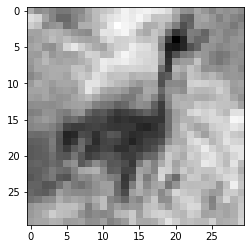

In [57]:
plt.imshow(output[0, 0].detach(), cmap='gray')
#plt.show()

### Padding enabled

In [62]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [65]:
conv.weight

Parameter containing:
tensor([[[[-0.0661,  0.0500,  0.0344],
          [ 0.0997,  0.1808,  0.1572],
          [-0.0427, -0.0397, -0.0702]],

         [[-0.1790,  0.1837,  0.1647],
          [-0.0789,  0.0786,  0.0435],
          [ 0.0256,  0.1623,  0.0511]],

         [[-0.1841, -0.0886,  0.1292],
          [-0.1804, -0.0700, -0.0147],
          [-0.1064, -0.0269,  0.1169]]]], requires_grad=True)

### Fill kernel weights by hands

- Let’s first zero out bias, just to remove any confounding factors, and 
- then set weights to a constant value so that each pixel in the output gets the mean of its neighbors. 

- For each 3 × 3 neighborhood:

In [69]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

conv.weight

Parameter containing:
tensor([0.], requires_grad=True)

Parameter containing:
tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]], requires_grad=True)

Parameter containing:
tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]], requires_grad=True)

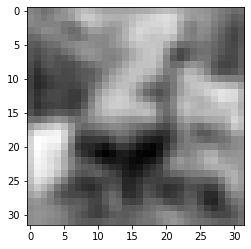

In [70]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')

## Edge detection kernel

Working out the weighted sum for an arbitrary pixel in position 2,2, as we did earlier for the generic convolution kernel, we get


o22 = $$\begin{pmatrix}i13 - i11 +\\\
      i23 - i21 +\\\
      i33 - i31\end{pmatrix}$$ 
      
      
which performs the difference of all pixels on the right of i22 minus the pixels on the left of i22. If the kernel is applied on a vertical boundary between two adjacent regions of different intensity, o22 will have a high value. If the kernel is applied on a region of uniform intensity, o22 will be zero. It’s an edge-detection kernel: the kernel highlights the vertical edge between two horizontally adjacent regions.



Parameter containing:
tensor([0.], requires_grad=True)

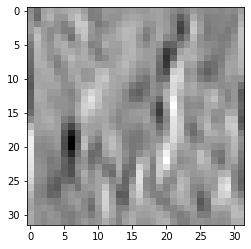

In [71]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()
    
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')

In [74]:
type(conv)
type(pool)

torch.nn.modules.conv.Conv2d

torch.nn.modules.pooling.MaxPool2d

### Max pooling

In [73]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
 
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

### An example Conv 2D

In [76]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...               
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [77]:
## .Not being able to do this kind of operation inside of nn.Sequential was an explicit design 
## choice by the PyTorch authors and was left that way for a long time; see the linked comments 
## from @soumith at https://github.com/pytorch/pytorch/issues/2486. 
## Recently, PyTorch gained an nn.Flatten layer.

model(img.unsqueeze(0))

RuntimeError: size mismatch, m1: [64 x 8], m2: [512 x 32] at /Users/distiller/project/conda/conda-bld/pytorch_1579022036889/work/aten/src/TH/generic/THTensorMath.cpp:136

### To fix the above problem of reshaping using view function, we have to define a new class

In [86]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        ## are we saying that 
        ## Interestingly, assigning an instance of nn.Module to an attribute in an nn.Module, 
        # as we did in the earlier constructor, automatically registers the module as a submodule.
        
        ## As a result of which, this allows the class Net to have access to the parameters 
        # of its submodules without further action by the user:
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
            out = self.pool1(self.act1(self.conv1(x)))
            out = self.pool2(self.act2(self.conv2(out)))
            out = out.view(-1, 8 * 8 * 8)   #  This reshape is what we were missing earlier
            out = self.act3(self.fc1(out))
            out = self.fc2(out)
            return out

model = Net()
 
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [87]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1562, -0.0231]], grad_fn=<AddmmBackward>)

## Skip connection or ResNet or residual network

In [88]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
 
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        ####. Here we are adding output of Relu and out1: skip connection
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

## Building deeper network

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        
        #The BatchNorm layer would cancel the effect of bias, so it is customarily left out.
        # so bias = False
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)  
        
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        
        #Uses custom initializations. kaiming_normal_ initializes with normal random elements 
        # with standard deviation as computed in the ResNet paper. 
        # The batch norm is initialized to produce output distributions that initially 
        # have 0 mean and 0.5 variance.
        torch.nn.init.kaiming_normal_(self.conv.weight,nonlinearity='relu')
        
        
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
 
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [89]:
#First, in init, we create nn.Sequential containing a list of ResBlock instances. 
# nn.Sequential will ensure that the output of one block is used as input to the next. 
# It will also ensure that all the parameters in the block are visible to Net. 
# Then, in forward, we just call the sequential to traverse the 100 blocks and generate the output:


# In the implementation, we parameterize the actual number of layers, 
# which is important for experimentation and reuse. Also, needless to say, 
# backpropagation will work as expected. Unsurprisingly, 
# the network is quite a bit slower to converge. 
# It is also more fragile in convergence. 
# This is why we used more-detailed initializations and trained our 
# NetRes with a learning rate of 3e - 3 instead of the 1e - 2 we used for the other networks. 
# We trained none of the networks to convergence, 
# but we would not have gotten anywhere without these tweaks.


class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        
        ## Sequential with list of blocks
        self.resblocks = nn.Sequential( *(n_blocks * [ResBlock(n_chans=n_chans1)])   )
        
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
 
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

## CNN Start

In [90]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

## Vectorize Data

We will create a batch data set of 128
Each surname is 2D matrix.  Number of rows 77, which are all the unique characters. 
17 are the number of columns. Maximum number of character in any surname.

So, each column has 77 long. Only one of them is set to 1
128, 77, 17

In [279]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)


In [280]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab, max_surname_length):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
            max_surname_length (int): the length of the longest surname
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab
        self._max_surname_length = max_surname_length

    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname
        Returns:
            one_hot_matrix (np.ndarray): a matrix of one-hot vectors
        """

        #print(f'len(self.surname_vocab) {len(self.surname_vocab)} self._max_surname_length {self._max_surname_length}')
        one_hot_matrix_size = (len(self.surname_vocab), self._max_surname_length)
        one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)
                               
        for position_index, character in enumerate(surname):
            character_index = self.surname_vocab.lookup_token(character)
            one_hot_matrix[character_index][position_index] = 1
        
        return one_hot_matrix

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)
        max_surname_length = 0

        for index, row in surname_df.iterrows():
            max_surname_length = max(max_surname_length, len(row.surname))
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        print('surname_vocab ',len(surname_vocab))
        return cls(surname_vocab, nationality_vocab, max_surname_length)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab, 
                   max_surname_length=contents['max_surname_length'])

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable(), 
                'max_surname_length': self._max_surname_length}


    

class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            name_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer
        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)


    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameDataset
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        surname_matrix = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_matrix,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


### Start Understanding surname data class

In [244]:
surname_df = pd.read_csv(surname_csv)
train_surname_df = surname_df[surname_df.split=='train']
#return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

In [245]:
surname_df.head()

,nationality,nationality_index,split,surname
0,Arabic,15,train,Totah
1,Arabic,15,train,Abboud
2,Arabic,15,train,Fakhoury
3,Arabic,15,train,Srour
4,Arabic,15,train,Sayegh


In [348]:
surname_vocab = Vocabulary(unk_token="@")
nationality_vocab = Vocabulary(add_unk=False)
max_surname_length = 0

for index, row in train_surname_df.iterrows():
    max_surname_length = max(max_surname_length, len(row.surname))
   
    for letter in row.surname:
        _= surname_vocab.add_token(letter)
    _=nationality_vocab.add_token(row.nationality)

print('len(nationality_vocab)', len(nationality_vocab))
print('len surname_vocab', len(surname_vocab))
print('len max_surname_length', max_surname_length)

len(nationality_vocab) 18
len surname_vocab 77
len max_surname_length 17


In [349]:
# max_surname_length
# nationality_vocab._token_to_idx
# nationality_vocab._idx_to_token

class_counts = surname_df.nationality.value_counts().to_dict()
print('class_counts and len', len(class_counts))
class_counts


def sort_key(item):
    return nationality_vocab.lookup_token(item[0])

sorted_counts = sorted(class_counts.items(), key=sort_key)

frequencies = [count for _, count in sorted_counts]
frequencies

class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
class_weights

class_counts and len 18


{'English': 2972,
 'Russian': 2373,
 'Arabic': 1603,
 'Japanese': 775,
 'Italian': 600,
 'German': 576,
 'Czech': 414,
 'Spanish': 258,
 'Dutch': 236,
 'French': 229,
 'Chinese': 220,
 'Irish': 183,
 'Greek': 156,
 'Polish': 120,
 'Korean': 77,
 'Scottish': 75,
 'Vietnamese': 58,
 'Portuguese': 55}

[1603,
 220,
 414,
 236,
 2972,
 229,
 576,
 156,
 183,
 600,
 775,
 77,
 120,
 55,
 2373,
 75,
 258,
 58]

tensor([0.0006, 0.0045, 0.0024, 0.0042, 0.0003, 0.0044, 0.0017, 0.0064, 0.0055,
        0.0017, 0.0013, 0.0130, 0.0083, 0.0182, 0.0004, 0.0133, 0.0039, 0.0172])

In [350]:
len(surname_vocab._token_to_idx)
len(surname_vocab._idx_to_token)
surname_vocab._idx_to_token[0]
surname_vocab._idx_to_token[1]

77

77

'@'

'T'

In [351]:
#convert to vector
len(surname_vocab), max_surname_length
one_hot_matrix_size = (len(surname_vocab), max_surname_length)
one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)
one_hot_matrix.shape

(77, 17)

(77, 17)

In [358]:
surname = 'Fakhoury'
for position_index, character in enumerate(surname):
    character_index = surname_vocab.lookup_token(character)
    one_hot_matrix[character_index][position_index] = 1
    print(character_index, position_index)

one_hot_matrix.shape

10 0
4 1
11 2
5 3
2 4
8 5
12 6
13 7


(77, 17)

In [356]:
one_hot_matrix[:4]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

In [346]:
#output_ch, input_cha, kernel_size + bias(number of output channel)

a = nn.Conv1d(in_channels=10, out_channels=7, kernel_size=3)

7 * 10 * 3 + 7

numel_list = [p.numel() for p in a.parameters()]
sum(numel_list), numel_list

# input going as shape torch.Size([128, 77, 17])
# 77 channels ( are the unique charaters ever seen in any surname)
# 17 lenght of any surname

# so, how does any surname looks. Say 'Teflon'


217

(217, [210, 7])

#### Understand Conv1d

In [412]:
my_input = torch.ones(1, 3, 5) # 1 is batch, 3 words, each word has 5 dimensions
my_input.shape

my_input

# we want number of dimensions as rows and number of words as columns
rand_arr_permute = my_input.clone().permute(0,2,1)

rand_arr_permute.shape
print(rand_arr_permute)

rand_arr_permute[0,:, 2]=0
print(rand_arr_permute)

conv1 = nn.Conv1d(5, 2, 2)
conv1.weight
conv1.bias

with torch.no_grad():
    conv1.weight.fill_(1)
    conv1.bias.fill_(0)
    print(torch.sum((rand_arr_permute[:,:,:2]*conv1.weight)))# + conv1.bias)
    
    output = conv1(rand_arr_permute)
    print(output)
    print(output.shape)

torch.Size([1, 3, 5])

tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]])

torch.Size([1, 5, 3])

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])
tensor([[[1., 1., 0.],
         [1., 1., 0.],
         [1., 1., 0.],
         [1., 1., 0.],
         [1., 1., 0.]]])


Parameter containing:
tensor([[[ 0.2114,  0.3161],
         [ 0.1838,  0.3037],
         [-0.2289, -0.0078],
         [ 0.1660,  0.1482],
         [-0.2486,  0.0397]],

        [[ 0.1582, -0.2616],
         [-0.2169,  0.1383],
         [-0.1542, -0.0966],
         [ 0.0433, -0.0915],
         [-0.1539, -0.0565]]], requires_grad=True)

Parameter containing:
tensor([ 0.0461, -0.1692], requires_grad=True)

Parameter containing:
tensor([[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]], requires_grad=True)

Parameter containing:
tensor([0., 0.], requires_grad=True)

tensor(20.)
tensor([[[10.,  5.],
         [10.,  5.]]])
torch.Size([1, 2, 2])


### End Understanding surname data class

In [283]:
# create dataset and vectorizer
surname_csv = './data/surnames/surnames_with_splits.csv'
save_surname_json = './data/surnames/vectorize.json'
dataset = SurnameDataset.load_dataset_and_make_vectorizer(surname_csv)
dataset.save_vectorizer(save_surname_json)

surname_vocab  77


In [284]:
## trying to understand following code

# dataset.set_split('train')
# batch_generator = generate_batches(dataset,batch_size=args.batch_size, device=args.device)

## here is how following function is defined

#def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):

#     dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
#                             shuffle=shuffle, drop_last=drop_last)

dataloader = DataLoader(dataset=dataset, batch_size=128,
                        shuffle=True, drop_last=True)

In [276]:
data_dict['x_surname'].shape

torch.Size([128, 77, 17])

In [290]:
for data_dict in dataloader:
    #print(data_dict)
    print(type(data_dict))
    print(len(data_dict))
    print(data_dict.keys())
    print(data_dict['x_surname'].shape)
    for name, tensor in data_dict.items():
        print(f' name is {name} shape = {tensor.shape}')
        #pass
    break

<class 'dict'>
2
dict_keys(['x_surname', 'y_nationality'])
torch.Size([128, 77, 17])
 name is x_surname shape = torch.Size([128, 77, 17])
 name is y_nationality shape = torch.Size([128])


In [291]:
for data_dict in dataloader:
    out_data_dict = {}
    for name, tensor in data_dict.items():
        out_data_dict[name] = data_dict[name].to(device)
    yield out_data_dict
        

SyntaxError: 'yield' outside function (<ipython-input-291-158885d86d54>, line 5)

In [338]:
class SurnameClassifier(nn.Module):
    def __init__(self, initial_num_channels, num_classes, num_channels):
        """
        Args:
            initial_num_channels (int): size of the incoming feature vector
            num_classes (int): size of the output prediction vector
            num_channels (int): constant channel size to use throughout network
        """
        super(SurnameClassifier, self).__init__()
        
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=initial_num_channels, 
                      out_channels=num_channels, kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3),
            nn.ELU()
        )
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x_surname, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_surname (torch.Tensor): an input data tensor. 
                x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        a = self.convnet(x_surname)
        print('the convet shape ', a.shape)
        features = a.squeeze(dim=2)
        #features = self.convnet(x_surname).squeeze(dim=2)
       
        prediction_vector = self.fc(features)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

In [339]:
num_channels = 256
len_surname_vocab = len(vectorizer.surname_vocab) # this is our input
len_nationality = len(vectorizer.nationality_vocab) # this is our output
num_of_output_of_first_hidden_layer = 256




print('input channel ', len_surname_vocab, 'output channel ', len_nationality, ' hidden layer output size ',num_of_output_of_first_hidden_layer )
classifier = SurnameClassifier(initial_num_channels=len_surname_vocab,
                               num_classes=len_nationality,
                               num_channels=num_of_output_of_first_hidden_layer)

len(list(classifier.parameters()))


numel_list = [p.numel() for p in classifier.parameters()]
sum(numel_list), numel_list

classifier.to('cpu')

input channel  77 output channel  18  hidden layer output size  256


10

(654610, [59136, 256, 196608, 256, 196608, 256, 196608, 256, 4608, 18])

SurnameClassifier(
  (convnet): Sequential(
    (0): Conv1d(77, 256, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (7): ELU(alpha=1.0)
  )
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

In [336]:
# for explanation see above
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

dataset.set_split('train')
batch_generator = generate_batches(dataset, 
                                   batch_size=128, 
                                   device='cpu')

classifier.train()

SurnameClassifier(
  (convnet): Sequential(
    (0): Conv1d(77, 256, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (7): ELU(alpha=1.0)
  )
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

In [322]:
## total number of batches available. Each batch is of size 128
for batch_index, batch_dict in enumerate(batch_generator):
    print(batch_index)
    print(batch_dict.keys())
    break

0
dict_keys(['x_surname', 'y_nationality'])


In [340]:
loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=0.001)


for batch_index, batch_dict in enumerate(batch_generator):
    optimizer.zero_grad()
    print('batch_dict size ', batch_dict['x_surname'].shape)

    # step 2. compute the output
    y_pred = classifier(batch_dict['x_surname'])
    break

batch_dict size  torch.Size([128, 77, 17])
the convet shape  torch.Size([128, 256, 1])
